# Classifying MNIST with a simple model and quantum embeddings

Inspired by:  https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

Useful imports

In [1]:
# for the Boson Sampler
import perceval as pcvl
#import perceval.providers.scaleway as scw  # Uncomment to allow running on scaleway

# for the machine learning model
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from boson_sampler import BosonSampler
from utils import MNIST_partial, accuracy, plot_training_metrics
from model import *

## Definition of the Boson Sampler

In [2]:
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()
# definition of the BosonSampler
# here, we use 30 photons and 2 modes

bs = BosonSampler(20,2, postselect = 2, session = session)
print(f"Boson sampler defined with number of parameters = {bs.nb_parameters}, and embedding size = {bs.embedding_size}")

#to display it
# pcvl.pdisplay(bs.create_circuit())
# define device to run the model

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE = {device}')

Boson sampler defined with number of parameters = 370, and embedding size = 190
DEVICE = cpu


## Dataset : a subset of MNIST dataset

In [3]:
# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split = 'train')
val_dataset = MNIST_partial(split='val')

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

In [4]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([10, 1, 28, 28])
Image label dimensions: torch.Size([10])


In [5]:
def training_step(batch, emb = None):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True  # Only needed for special cases
    # if self.embedding_size:
    #     out = self(images, emb.to(self.device)) ## Generate predictions
    # else:
    # images = images.reshape(-1,1,28,28)
    # print(images.shape)

    # out = model(images) ## Generate predictions
    # loss = F.cross_entropy(out, labels)
    # acc = accuracy(out, labels, task="multiclass", num_classes=10)
    loss, acc = model((images, labels)) ## Generate predictions
    
    # loss = F.cross_entropy(out, labels) ## Calculate the loss
    # acc = accuracy(out, labels)
    return loss, acc

def validation_step(batch, emb =None):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True  # Only needed for special cases
    # if self.embedding_size:
    #     out = self(images, emb.to(self.device)) ## Generate predictions
    # # else:
    # out = model(images) ## Generate predictions
    # loss = F.cross_entropy(out, labels)
    # acc = accuracy(out, labels, task="multiclass", num_classes=10)
    loss, acc = model((images,labels)) ## Generate predictions
    return({'val_loss':loss, 'val_acc': acc})

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

def epoch_end(epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    return result['val_loss'], result['val_acc']

# training loop
def fit(epochs, lr, model, train_loader, val_loader, bs: BosonSampler, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func([{'params': model.model.fc.parameters(), 'lr': lr},{'params': model.model.conv1.parameters(), 'lr': lr}])
    # creation of empty lists to store the training metrics
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    for epoch in range(epochs):
        training_losses, training_accs = 0, 0
        ## Training Phase
        for step, batch in enumerate(tqdm(train_loader)):
            # # embedding in the BS
            # if model.embedding_size:
            #     images, labs = batch
            #     images = images.squeeze(0).squeeze(0)
            #     t_s = time.time()
            #     embs = bs.embed(images,1000)
            #     loss,acc = model.training_step(batch,emb = embs.unsqueeze(0))

            # else:
            
            loss,acc = training_step(batch)
            # loss.requires_grad = True
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Backpropagation with boson sampling noise
            # for param in model.parameters():
            #     param.grad = param.grad + bs(param.grad.shape, scale=0.001)

            training_losses+=int(loss.detach())
            training_accs+=int(acc.detach())
            # if model.embedding_size and step%100==0:
            #     print(f"STEP {step}, Training-acc = {training_accs/(step+1)}, Training-losses = {training_losses/(step+1)}")
        
        ## Validation phase
        outputs = [validation_step(batch) for batch in val_loader]
        result = (validation_epoch_end(outputs))
        # result = evaluate(model, val_loader, bs)
        validation_loss, validation_acc = result['val_loss'], result['val_acc']
        epoch_end(epoch, result)
        history.append(result)

        ## summing up all the training and validation metrics
        training_loss = training_losses/len(train_loader)
        training_accs = training_accs/len(train_loader)
        train_loss.append(training_loss)
        train_acc.append(training_accs)
        val_loss.append(validation_loss)
        val_acc.append(validation_acc)

        # plot training curves
        plot_training_metrics(train_acc,val_acc,train_loss,val_loss)
    return(history)


## Training loop

In [6]:
# # weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
# model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights)
# # model_hybrid = torchvision.models.resnet18(pretrained=True)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
# model.fc = nn.Linear(in_features=512, out_features=10)

# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the last layer
# for param in model.conv1.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

# # Notice that model_hybrid.fc is the last layer of ResNet18
# # model_hybrid.fc = DressedQuantumNet(bs, bs.nb_parameters)
# # model_hybrid.fc = nn.Linear(in_features=512, out_features=10)
# model = model.to(device)
# # print(model_hybrid)

In [7]:
# # weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
# model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights)
# # model_hybrid = torchvision.models.resnet18(pretrained=True)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
# model.fc = DressedQuantumNet(bs, bs.nb_parameters)

# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the last layer
# for param in model.conv1.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

# # Notice that model_hybrid.fc is the last layer of ResNet18
# # model_hybrid.fc = DressedQuantumNet(bs, bs.nb_parameters)
# # model_hybrid.fc = nn.Linear(in_features=512, out_features=10)
# model = model.to(device)
# # print(model_hybrid)

In [8]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [9]:
from pre_trained import *
# trainer = Trainer(
#     fast_dev_run=False,
#     # logger=TensorBoardLogger("cifar10", name='resnet18'),
#     deterministic=True,
#     log_every_n_steps=1,
#     max_epochs=100,
#     precision=32,
# # )

# model = CIFAR10Module(minst=True)
# # data = CIFAR10Data()

# for param in model.parameters():
#     param.requires_grad = False  # Freeze all layers

# # Unfreeze the last layer
# for param in model.model.conv1.parameters():
#     param.requires_grad = True
# for param in model.model.avgpool.parameters():
#     param.requires_grad = True
# pretrained_dict = torch.load("state_dicts/resnet18.pt")  # Path to saved weights
# model_dict = model.state_dict()

# # Remove 'conv1' weights from pretrained_dict to avoid shape mismatch
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if "conv1" or "avgpool" not in k}

# # Update the current model dictionary
# model_dict.update(pretrained_dict)

# # model_hybrid.fc = DressedQuantumNet(bs, bs.nb_parameters)
# # # model_hybrid.fc = nn.Linear(in_features=512, out_features=10)
# # model = model_hybrid.to(device)

# # Load the modified weights
# model.load_state_dict(model_dict, strict=False) 
# model.to(device)

# model_hybrid.fc = DressedQuantumNet(bs, bs.nb_parameters)
# # model_hybrid.fc = nn.Linear(in_features=512, out_features=10)
# model = model_hybrid.to(device)
# model.load_state_dict(torch.load('state_dicts/resnet18.pt'), strict=False)

# trainer.test(model, val_loader)

In [10]:
# train the model with the chosen parameters
# experiment = fit(epochs = 20, lr = 0.001, model = model, train_loader = train_loader, val_loader = val_loader, bs=bs)

In [ ]:
trainer = Trainer(
    fast_dev_run=False,
    # logger=TensorBoardLogger("cifar10", name='resnet18'),
    deterministic=True,
    log_every_n_steps=1,
    max_epochs=100,
    precision=32,
)
model = CIFAR10Module(minst=True, quantum=bs)
model.model.fc = DressedQuantumNet(bs, bs.nb_parameters)

for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the last layer
for param in model.model.fc.parameters():
    param.requires_grad = True

for param in model.model.conv1.parameters():
    param.requires_grad = True

for param in model.model.avgpool.parameters():
    param.requires_grad = True

pretrained_dict = torch.load("state_dicts/resnet18.pt")  # Path to saved weights
model_dict = model.state_dict()

# Remove 'conv1' weights from pretrained_dict to avoid shape mismatch
pretrained_dict = {k: v for k, v in pretrained_dict.items() if "conv1" or "fc" not in k}

# Update the current model dictionary
model_dict.update(pretrained_dict)


# Load the modified weights
model.load_state_dict(model_dict, strict=False) 
model.to(device)
# trainer.fit(model, MinstData())
# trainer.test()
# trainer.test(model, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


CIFAR10Module(
  (criterion): CrossEntropyLoss()
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05

100%|██████████| 600/600 [20:30<00:00,  2.05s/it]


Epoch [0], val_loss: 2.3041, val_acc: 10.1667


100%|██████████| 600/600 [20:06<00:00,  2.01s/it]


Epoch [1], val_loss: 2.3041, val_acc: 9.8333


100%|██████████| 600/600 [19:09<00:00,  1.92s/it]


Epoch [2], val_loss: 2.3041, val_acc: 9.8333


100%|██████████| 600/600 [19:08<00:00,  1.91s/it]


Epoch [3], val_loss: 2.3041, val_acc: 9.6667


100%|██████████| 600/600 [19:10<00:00,  1.92s/it]


Epoch [4], val_loss: 2.3040, val_acc: 9.6667


 75%|███████▍  | 448/600 [52:03<17:39,  6.97s/it]    


KeyboardInterrupt: 

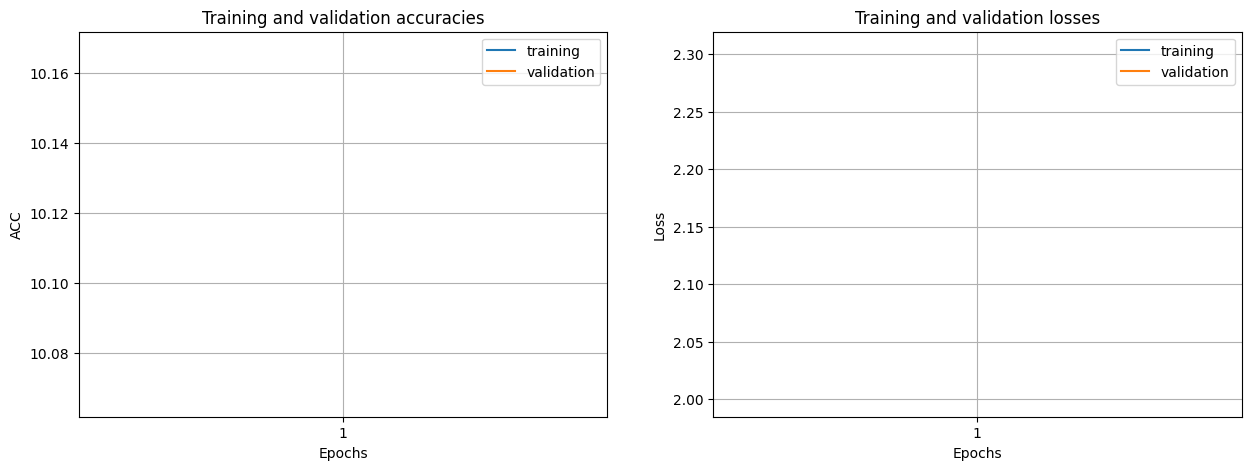

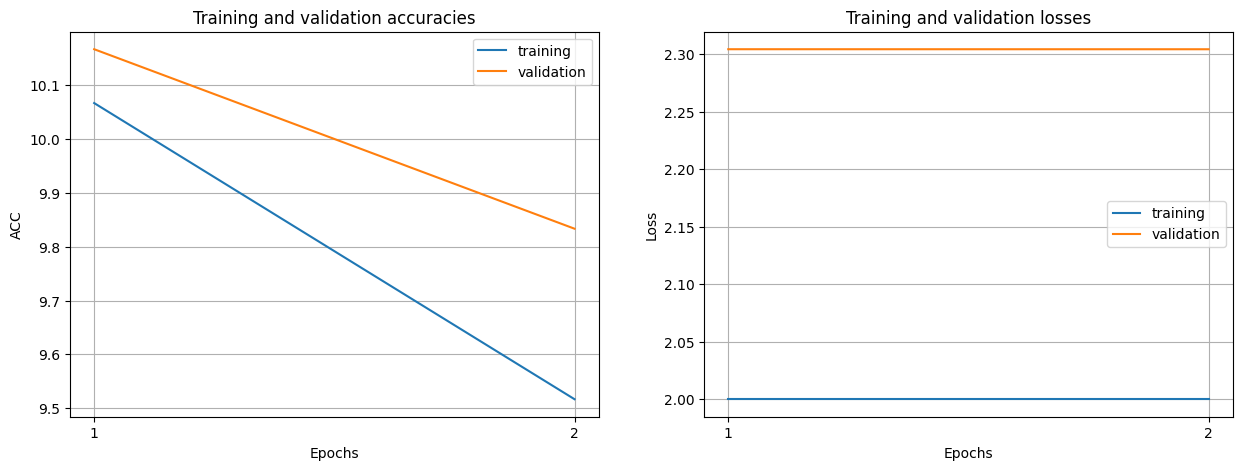

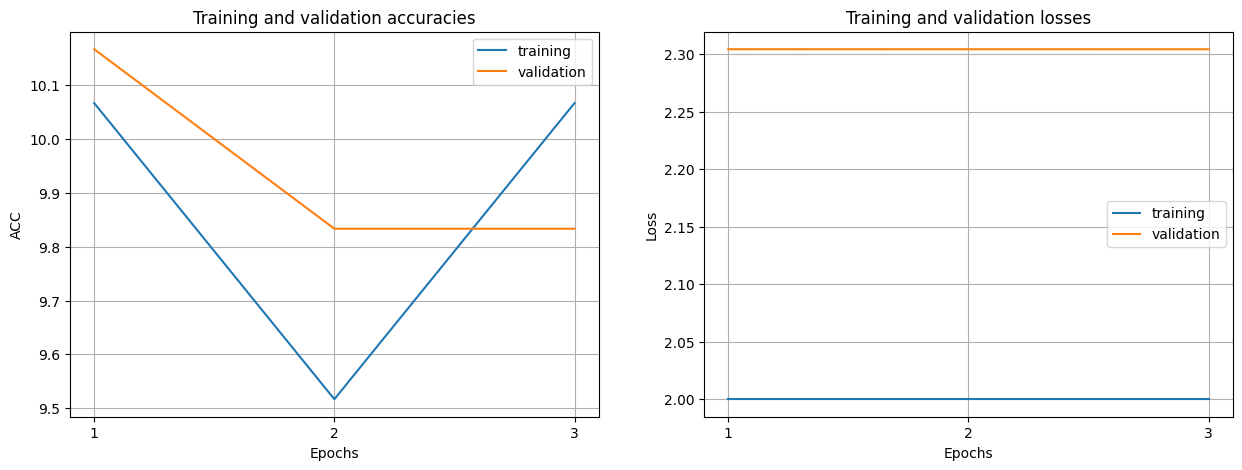

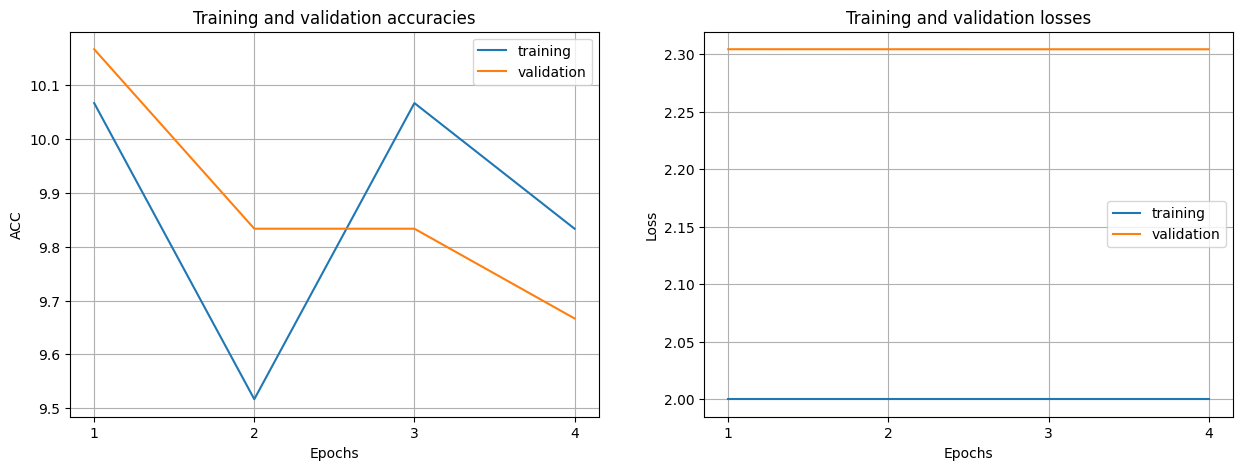

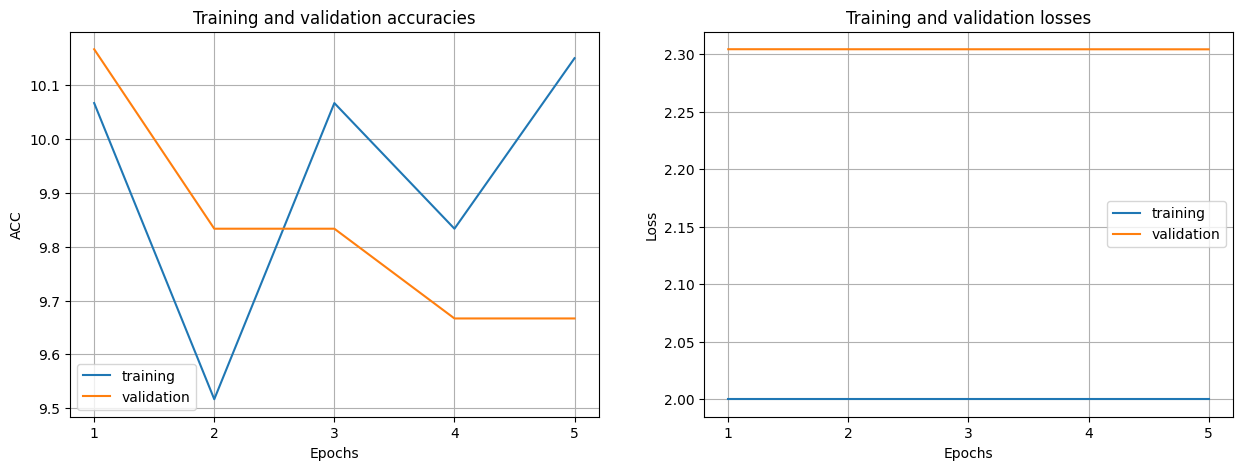

In [12]:
# train the model with the chosen parameters
experiment = fit(epochs = 20, lr = 0.001, model = model, train_loader = train_loader, val_loader = val_loader, bs=bs)

## Model training

In [ ]:
# train the model with the chosen parameters
# experiment = fit(epochs = 5, lr = 0.001, model = model, train_loader = train_loader, val_loader = val_loader, bs=bs)

In [ ]:
# train the model with the chosen parameters
# experiment = fit(epochs = 5, lr = 0.001, model = model, train_loader = train_loader, val_loader = val_loader, bs=bs)

In [ ]:
# train the model with the chosen parameters
# experiment = fit(epochs = 5, lr = 0.001, model = model, train_loader = train_loader, val_loader = val_loader, bs=bs)

In [ ]:
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")  # Should print True for 'fc' layer

In [ ]:
# end session if needed
if session is not None:
    session.stop()